<H1>Patient's mortality prediction from 24 hours of ICU data</H1>

Source: https://www.kaggle.com/c/widsdatathon2020/data

1. Objective: Predict the survival of the patient based on the first 24 hours data from Intesive Care Unit (ICU) in a hospital

2. Mapping real world problem to ML problem
  
  2.1 Type of machine learning problem:
        The output is binary and thus this is a binary classification
  2.2 Metric for performance model
       - Logistic loss is the primary performance metric
       - Area under the Receiver Operating Characteristic (ROC) curve is the secondary performance metric. ROC-AUC is the performance metric requested by Kaggle
      
       

3. Exploratory Data Analysis
    3.1 Understanding Features
    3.2 Exploration of APACHE 4 probabilistic prediction values and its correlation with hospital death
    

1. Variance threshold = 0.1
     Columns removed: 'readmission_status' 'gcs_unable_apache' 'ph_apache' 'd1_arterial_ph_max'
     'aids' 'leukemia' 'lymphoma'

2. Features with >90% of the data is missing:
    Columns removed: 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max',
    'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min'

3. Split features and target variable

4. Split test, train dataset

5. Create dummy variables for categorical variables

6. Standardize features except categorical variables

7. Impute median in missing values position

In [135]:
### Importing required modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, make_scorer, log_loss
from sklearn.linear_model import LogisticRegression, SGDClassifier
from joblib import dump, load
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
#from xgboost import XGBClassifier

In [37]:
## Load csv file into pandas
df = pd.read_csv("training_v2.csv")
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


3. Exploratory Data Analysis

In [7]:
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
encounter_id                     91713 non-null int64
patient_id                       91713 non-null int64
hospital_id                      91713 non-null int64
hospital_death                   91713 non-null int64
age                              87485 non-null float64
bmi                              88284 non-null float64
elective_surgery                 91713 non-null int64
ethnicity                        90318 non-null object
gender                           91688 non-null object
height                           90379 non-null float64
hospital_admit_source            70304 non-null object
icu_admit_source                 91601 non-null object
icu_id                           91713 non-null int64
icu_stay_type                    91713 non-null object
icu_type                         91713 non-null object
pre_icu_los_days                 91713 non-null float64
readmission_

- There are 91713 observations with 186 features in the dataset. 
- Out of 186 features, 8 are categorical features
- Features can be grouped into five categories:
    - ID
    - Rest (Chronic health condition, admission status)
    - apache values (Apache 4 scores)
    - d1 -- Patient's vital or lab measured during the first 24 hours (d1 - day1)
    - h1 -- Patient's vital or lab measured during the first hour (h1 - hour 1)

What does APACHE mean?

Reference: https://www.merckmanuals.com/professional/critical-care-medicine/approach-to-the-critically-ill-patient/critical-care-scoring-systems

Acute Physiologic Assessment and Chronic Health Evaluation (APACHE)

Three versions of APACHE scores are available
APACHE II
APACHE III
APACHE IV

APACHE scores were calculated based on patient's physiological and other health conditions to estimate ICU mortality

<I>"APACHE scores were developed to grade the severity of illness in critically ill patients. These systems are moderately accurate in predicting individual survival. However, these systems are more valuable for monitoring quality of care and for conducting research studies because they allow comparison of outcomes among groups of critically ill patients with similar illness severity." </I>

- This data has apache 4 probability scores for inhospital and in ICU mortality

From the dictionary provided, it is clear that the following 2 features provides the probability of patient's mortality in hospital and in ICU respectively:
    - apache_4a_hospital_death_prob 
    - apache_4a_icu_death_prob

In [172]:
### Separating features by tags identified above
print("#"*20 + "Features with id" + "#"*20)
id_features = df.columns[df.columns.str.endswith('id')]
print(id_features)
print("#"*20 + "apache values" + "#"*20)
apache_features = df.columns[df.columns.str.contains('apache')]
print(apache_features)
print("#"*20 + "d1 values" + "#"*20)
d1_features = df.columns[df.columns.str.contains('d1')]
print(d1_features)
print("#"*20 + "h1 values" + "#"*20)
h1_features = df.columns[df.columns.str.contains('h1')]
print(h1_features)
print("#"*20 + "Rest of features" + "#"*20)
df.columns[~df.columns.str.contains("|".join(['id$','apache','d1','h1']))]

####################Features with id####################
Index(['encounter_id', 'patient_id', 'hospital_id', 'icu_id'], dtype='object')
####################apache values####################
Index(['albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache',
       'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache',
       'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object')
####################d1 values####################
Index(['d1_diasbp_invasive_max', 'd1_

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity',
       'gender', 'height', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status',
       'weight', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis'],
      dtype='object')

In [250]:
### 3.2 Understanding the APACHE 4 prediction values
df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob', 'hospital_death']].describe()#sort_values(by='hospital_death', ascending = False)
## some probabilistic prediction are negative??

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,hospital_death
count,83766.000000,83766.000000,91713.000000
mean,0.086787,0.043955,0.086302
std,0.247569,0.217341,0.280811
min,-1.000000,-1.000000,0.000000
25%,0.020000,0.010000,0.000000
50%,0.050000,0.020000,0.000000
75%,0.130000,0.060000,0.000000
max,0.990000,0.970000,1.000000


Some predictions are negative. One interpreation for negative probability could be that features underlying the APACHE probabilistic model may have missing values. Let us check:<br>
Here is the logic:<br>
if # observations with -1 == # observations with missing values in any one feature <br>
then <br>
probability prediction = -1

In [197]:
print("Hypothesis: Apache 4a in hospital death prediction is -1 for observation with missing values")
print("# observation with -1 prediction:", df[df.apache_4a_hospital_death_prob == -1].shape[0])
print("Number of observations with missing values in any one feature:", df[df.apache_4a_hospital_death_prob == -1].isnull().any(axis=1).sum()
     )
print("Hypothesis: Apache 4a in ICU death prediction is -1 for observation with missing values")
print("# observation with -1 prediction:", df[df.apache_4a_icu_death_prob == -1].shape[0])
print("Number of observations with missing values in any one feature:", df[df.apache_4a_icu_death_prob == -1].isnull().any(axis=1).sum())

Hypothesis: Apache 4a in hospotal death prediction is -1 for observation with missing values
# observation with -1 prediction: 2371
Number of observations with missing values in any one feature: 2371
Hypothesis: Apache 4a in ICU death prediction is -1 for observation with missing values
# observation with -1 prediction: 2230
Number of observations with missing values in any one feature: 2230


For both in hospital and in ICU, the assumption is True <br>
    # observations with -1 == # observations with missing values in any one feature 

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,hospital_death
apache_4a_hospital_death_prob,1.000000,0.864118,0.481129
apache_4a_icu_death_prob,0.864118,1.000000,0.425696
hospital_death,0.481129,0.425696,1.000000


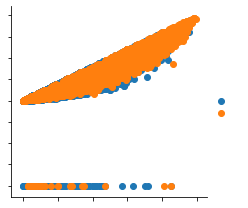

In [252]:
### dataframe with apache mortality prediction -1 and NAN removed
## Dropping negative values
## We know that there are 2371 rows with negative values for inhospital death
df_mort_pred = df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob', 'hospital_death']].copy()
df_mort_pred.drop(df_mort_pred[df_mort_pred.apache_4a_hospital_death_prob == -1].index, inplace = True)
sns.FacetGrid(df_mort_pred, hue = "hospital_death").map(plt.scatter, "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob").add_legend()
df_mort_pred.corr()

apache 4 predictions for in hospital mortality is linearly correlated with that of ICU mortality

3.3 Understangin missing values

In [281]:
print("Number of features with missing values:", sum(df.isna().sum() > 0))
print("Features without missing values",df.columns[~df.isnull().any()])
print("Any observation with missing values for all features?",df.loc[:, df.columns != 'hospital_death'].isnull().all(axis = 1).any())
print("List of features with >90% data missing:", list(df.columns[df.isna().sum()/df.shape[0] > 0.9]))

Number of features with missing values: 175
Features without missing values Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death',
       'elective_surgery', 'icu_id', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'readmission_status', 'apache_post_operative'],
      dtype='object')
Any observation with missing values for all features? False
List of features with >90% data missing: ['h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min']


- 175 features has missing values in it
- Target feature "hospital_death" does not have missing value
- These features has more than 90% of the data missing and thus, they will be removed from the dataset:'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min'

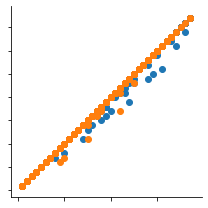

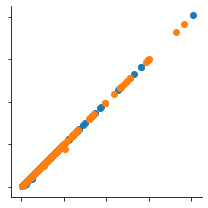

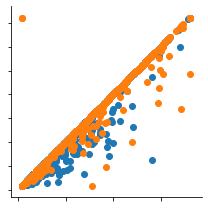

In [304]:
sns.FacetGrid(df, hue = "hospital_death").map(plt.scatter, "h1_albumin_max", "h1_albumin_min")
plt.show()
sns.FacetGrid(df, hue = "hospital_death").map(plt.scatter, "h1_bilirubin_max", "h1_bilirubin_min")
plt.show()
sns.FacetGrid(df, hue = "hospital_death").map(plt.scatter, "h1_lactate_max", "h1_lactate_min")
plt.show()

In [8]:
################################################################
######## Analysis
### 1. Feature selection: checking for very low variance in the dataframe
################################################################
#Split numeric and categorical variables as variance
df_numeric = df.select_dtypes(include = [float, int])
df_object = df.select_dtypes(include = [object])

###### Calculating variance for all numeric type feature and dropping fetaures with variance < 0.01
print("Columns with <0.01 variance dropped", df_numeric.columns[df_numeric.var() <=0.01].values)
#df_numeric.var().sort_values()[0:7]
df_feat_sel = df.drop(columns = df_numeric.columns[df_numeric.var() <0.01] )

###### Calculating variance for all object type feature and dropping features with single value
print("--------- Object typed features ----------")
for f in df_object:
    print("# Unique values in {} is {}".format(f, df_object[f].nunique()))

Columns with <0.01 variance dropped ['readmission_status' 'gcs_unable_apache' 'ph_apache' 'd1_arterial_ph_max'
 'aids' 'leukemia' 'lymphoma']
--------- Object typed features ----------
# Unique values in ethnicity is 6
# Unique values in gender is 2
# Unique values in hospital_admit_source is 15
# Unique values in icu_admit_source is 5
# Unique values in icu_stay_type is 3
# Unique values in icu_type is 8
# Unique values in apache_3j_bodysystem is 11
# Unique values in apache_2_bodysystem is 10


* 7 numeric columns were dropped from the dataset as their variance is very small <.01. 
* All the object typed features in dataset have >1 unique values and thus they are not dropped

In [9]:
################################################################
### 2. Understanding missing data and removing features with >90% of missing data
################################################################
print("Number of features with missing values:", sum(df_feat_sel.isna().sum() > 0))
#print("Features that do not have any missing values:", df.columns[df.isna().sum() == 0])
#print("Features with >90% of data missing:", df.columns[(df.isna().sum()/df.shape[0])>0.90] )
# - For class type 1 or type 0, does any of the feature has all missing values?
print("For class type 1 or type 0, does any of the feature has all missing values?")
print(df_feat_sel.set_index('hospital_death').isna().all(level=0).any().any())
# - List all the features that have >95% of the data missing -- drop it or if variance is high -- impoute it
feat_very_low_var = df_feat_sel.columns[df_feat_sel.isna().sum()/df_feat_sel.shape[0] > 0.9]
print("Following features have >90% of the data missing and they will be deleted:",
      feat_very_low_var)

#df_90mis = df_feat_sel[['h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max',
#       'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min']]
# df_90mis[df_90mis.notnull().any(axis=1)] # just to view this dataframe that has data
df_feat_sel = df_feat_sel.drop(columns = feat_very_low_var)
df_feat_sel.shape

Number of features with missing values: 169
For class type 1 or type 0, does any of the feature has all missing values?
False
Following features have >90% of the data missing and they will be deleted: Index(['h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max',
       'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min'],
      dtype='object')


(91713, 173)

- Out of 186 features, 175 features have missing values in them. 
- More than 90% of the data is missing for 6 features and they are dropped
- Missing values will be replaced with median of the feature in next few steps
- All together, 13 features are dropped from the dataset: readmission_status', 'gcs_unable_apache', 'ph_apache', 'd1_arterial_ph_max', 'aids', 'leukemia', 'lymphoma', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min'

In [10]:
df_feat_sel.nunique().sort_values(ascending = False)
df_feat_sel = df_feat_sel.drop(columns = ['encounter_id', 'patient_id'])
df_feat_sel.shape

(91713, 171)

Features "Encounter_id" and "Patient ID" have unique values and thus they are dropped

In [11]:
corr_matrix = df_feat_sel.corr()

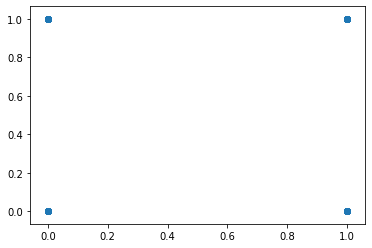

In [12]:
plt.scatter(df_feat_sel.cirrhosis, df_feat_sel.hepatic_failure)
#df_feat_sel[['cirrhosis', 'hepatic_failure']]

- Cirrhosis and hepatic_failure are strongly linearly correlated

In [13]:
##########################################################
#3. Is this a imbalanced dataset?
##########################################################
df_feat_sel.hospital_death.value_counts(normalize = True)

0    0.913698
1    0.086302
Name: hospital_death, dtype: float64

This is a heavily imbalanced dataset with ~91% of the data belonging to "0" class or survived. To overcome this, we will use SMOTE technique to oversample the minority class. Before using SMOTE, we need to convert categorical variables to dummy variables

In [14]:
##########################################################
### 4. Split the features and target variable
##########################################################
y = df_feat_sel['hospital_death']
X = df_feat_sel.drop(columns = ['hospital_death'])

##########################################################
## Split features and variables to train and test data set
##########################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
print(X_train.shape)
print(X_test.shape)

(73370, 170)
(18343, 170)


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [16]:
#Building pipeline for input transformation

num_attributes = X_train.select_dtypes(exclude = 'object').columns
obj_attributes = X_train.select_dtypes(include = 'object').columns

pipeline_num = Pipeline([('attributes',DataFrameSelector(num_attributes)),
                          ('standardization', StandardScaler()), 
                         ('imputer', SimpleImputer(strategy = 'median'))])
pipeline_obj = Pipeline([('attributes',DataFrameSelector(obj_attributes)),
                         ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'other')),
                        ('onehotencode', OneHotEncoder(handle_unknown='ignore'))])

pipeline_full = FeatureUnion(transformer_list=[("numerical_features", pipeline_num),
                                               ("categorical_features", pipeline_obj)])



In [17]:
x_train = pipeline_full.fit_transform(X_train)
x_test = pipeline_full.transform(X_test)

In [18]:
############################################################################
## Oversampling datapoints with minority class to make it a balanced dataset
############################################################################
sm = SMOTE()
X_train_os, y_train_os = sm.fit_resample(x_train, y_train)
print("After oversampling, x_train shape is {} and y_train shape is {}".format(X_train_os.shape, 
                                                                               y_train_os.shape))

After oversampling, x_train shape is (134076, 228) and y_train shape is (134076,)


In [99]:
### Defininig functions for calculating Precision, Recall, F1-score and AUC for ROC and PRcurve

### Run all models with default parameter and downselect one and fine tune it later
def evaluate_model(model, train_data_x, train_data_y):
    '''Returns the CV score of each model'''
    return cross_val_score(model, train_data_x, train_data_y, scoring = 'roc_auc', cv = 5)

def classification_metrics(model, test_data_x, test_data_y):
    '''Returns metric for classification model in the form of tuple: (precision, recall, auc P-R, auc - ROC, confusion matrix)'''
    predicted_test_data_y = model.predict(test_data_x)
    predicted_test_data_y_prob = model.predict_proba(test_data_x)
    precision = precision_score(test_data_y, predicted_test_data_y)
    recall = recall_score(test_data_y, predicted_test_data_y)
    precision_l, recall_l, threshold = precision_recall_curve(test_data_y, predicted_test_data_y_prob[:,1])
    auc_pr = auc(recall_l, precision_l)
    auc_roc = roc_auc_score(test_data_y, predicted_test_data_y_prob[:,1])
    cm = confusion_matrix(test_data_y, predicted_test_data_y)     
    ll = log_loss(test_data_y, predicted_test_data_y)
    return (precision, recall, auc_pr, auc_roc, cm, ll)
#def custom_pr_auc(y_true, y_pred):
#    p, r, thrshld = precision_recall_curve(test_data_y, predicted_test_data_y_prob[:,1])
#    auc_pr = auc(r, p)
#    return auc_pr

#pr_auc = make_scorer(auc(precision_recall_curve()[1],auc(precision_recall_curve()[0]),
#                     greater_is_better=True, needs_proba=False, needs_threshold=False, **kwargs)

scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 
          'roc':'roc_auc'}


In [20]:
#### Modelling: KNN
## Logistic regression with balanced data - oversampling and unweighted model
#knn_os = knn()
#knn_os.fit(X_train_os, y_train_os)
#knn_os.score(x_test, y_test)
#knn_os_cv = cross_val_score(knn_os, X_train_os, y_train_os, scoring = "f1", cv = 2)
#print("Averge CV score for KNN is {%3f} +- {%3f}".format(lr_os_cv.mean(), lr_os_cv.std()))

# Test data and metrics
#knn_os.fit(X_train_os, y_train_os)
#classification_metrics(lr_os,x_test, y_test)

In [84]:
#### Modelling: DummyClassifier for reference
dummy = DummyClassifier(random_state=42)
dummy_os = cross_validate(dummy, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
dummy.fit(X_train_os, y_train_os)
print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(dummy,x_test, y_test)))
#classification_metrics(dummy,x_test, y_test)

Precision: 0.0841385300184562 
 Recall: 0.4895767530006317 
 P-R AUC: 0.3088823920955986 
 ROC-AUC:  0.49311773210890775 
 Confusion Matrix:  [[8324 8436]
 [ 808  775]] 



Dummy classifier's metrics are as shown above. If any of our model's ROC-AUC is similar to 0.5, then it is a no-skill classifier

In [102]:
alpha = [10 ** x for x in range(-5, 2)]

In [109]:
#### Modelling: Logistic Regression with regularization via SGD
#roc_metric = []
log_loss_metric = []

for i in alpha:
    sgd = SGDClassifier(alpha = i, loss = 'log', random_state=42)
    sgd_os = cross_validate(sgd, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
    sgd.fit(X_train_os, y_train_os)
    sgd_cal = CalibratedClassifierCV(sgd)
    sgd_cal.fit(X_train_os, y_train_os)
    #roc_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-3])
    log_loss_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-1])
    print("Alpha: ", i, "Log loss: ", classification_metrics(sgd_cal,x_test, y_test))
    #print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(sgd,x_test, y_test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  1e-05 Log loss:  (0.2641629535327817, 0.786481364497789, 0.49689687852356174, 0.874643738588855, array([[13292,  3468],
       [  338,  1245]]), 7.166622469766014)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.0001 Log loss:  (0.26454468802698144, 0.7927984838913456, 0.5030981477929198, 0.8769915510412694, array([[13271,  3489],
       [  328,  1255]]), 7.187335729968273)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.001 Log loss:  (0.27262954203397116, 0.801010739102969, 0.51104940106597, 0.8811157329441545, array([[13377,  3383],
       [  315,  1268]]), 6.963261197540536)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.01 Log loss:  (0.27412044031944743, 0.8022741629816803, 0.5117866911106052, 0.8809723539335753, array([[13397,  3363],
       [  313,  1270]]), 6.921835636147273)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.1 Log loss:  (0.2711101585940849, 0.799115603284902, 0.5004484061951087, 0.8767627250756471, array([[13359,  3401],
       [  318,  1265]]), 7.002803731316193)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  1 Log loss:  (0.2567033880690085, 0.7801642451042324, 0.4694693335130113, 0.8623928991959618, array([[13184,  3576],
       [  348,  1235]]), 7.388814148941825)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  10 Log loss:  (0.2365528072241853, 0.7612128869235628, 0.4416727793885975, 0.8422223671256504, array([[12871,  3889],
       [  378,  1205]]), 8.034676362181209)


In [134]:
#### Modelling: Multinomial Naive Bayes
#roc_metric = []
#ls = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
#log_loss_metric_nb = []
#for i in ls:
nb = GaussianNB()
nb_os = cross_validate(nb, X_train_os.toarray(), y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
print("-"*10 + "Cross-Validate results" + "-"*10)
print(nb_os)
nb.fit(X_train_os.toarray(), y_train_os)
nb_cal = CalibratedClassifierCV(nb)
nb_cal.fit(X_train_os.toarray(), y_train_os)
    #roc_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-3])
#    log_loss_metric_nb.append(classification_metrics(nb_cal,x_test, y_test)[-1])
print("Log loss: ", classification_metrics(nb_cal,x_test.toarray(), y_test)[-1])
    #print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(sgd,x_test, y_test)))

----------Cross-Validate results----------
{'fit_time': array([0.465276  , 0.43983722, 0.43284607]), 'score_time': array([0.47356105, 0.44723082, 0.44215202]), 'test_acc': array([0.73326322, 0.74668845, 0.74326501]), 'train_acc': array([0.73966258, 0.74601718, 0.74441735]), 'test_prec': array([0.6916149 , 0.73941368, 0.71029014]), 'train_prec': array([0.69635917, 0.73572164, 0.7113067 ]), 'test_rec': array([0.84194039, 0.76188132, 0.82166831]), 'train_rec': array([0.8499284 , 0.76785554, 0.8227647 ]), 'test_roc': array([0.81083711, 0.81191894, 0.81081737]), 'train_roc': array([0.81467915, 0.81240982, 0.81160584])}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss:  10.652028386948396


In [28]:
#### Modelling: Logistic Regression
## Logistic regression with balanced data - oversampling and unweighted model
lr_os = LogisticRegression(penalty = 'l1', C = 0.8)
lr_os_cv = cross_validate(lr_os, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
# = cross_val_score(lr_os, X_train_os, y_train_os, scoring = "f1", cv = 3)
#print("Averge CV score for Logistic Regression is {} +- {}".format(lr_os_cv.mean(), lr_os_cv.std()))

# Test data and metrics
lr_os.fit(X_train_os, y_train_os)
classification_metrics(lr_os,x_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.26956894702980916,
 0.7940619077700568,
 0.5083974964846747,
 0.8788855938016847,
 array([[13354,  3406],
        [  326,  1257]]))

In [137]:
#### Modelling: SVM
#roc_metric = []
log_loss_metric_svm = []

for i in alpha:
    svm = LinearSVC(C = i, loss = 'hinge')
    svm_os = cross_validate(sgd, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
    svm.fit(X_train_os, y_train_os)
    svm_cal = CalibratedClassifierCV(svm)
    svm_cal.fit(X_train_os, y_train_os)
    #roc_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-3])
    log_loss_metric.append(classification_metrics(svm_cal,x_test, y_test)[-1])
    print("Alpha: ", i, "Log loss: ", classification_metrics(svm_cal,x_test, y_test))
    #print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(sgd,x_test, y_test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  1e-05 Log loss:  (0.26098729431368467, 0.7915350600126342, 0.4694994946929005, 0.8669030058331587, array([[13212,  3548],
       [  330,  1253]]), 7.302197668382814)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.0001 Log loss:  (0.2693947144075021, 0.7984838913455464, 0.5001739922665726, 0.8778242725135955, array([[13332,  3428],
       [  319,  1264]]), 7.055527240457997)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.001 Log loss:  (0.27212341975573173, 0.8022741629816803, 0.5084055377635498, 0.8810413673322005, array([[13363,  3397],
       [  313,  1270]]), 6.985857093037618)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

Alpha:  0.01 Log loss:  (0.270229663017815, 0.7953253316487682, 0.5060736275577518, 0.8808506476178127, array([[13360,  3400],
       [  324,  1259]]), 7.012218389898601)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

Alpha:  0.1 Log loss:  (0.26993996569468265, 0.7953253316487682, 0.5037086057399762, 0.8797250620781363, array([[13355,  3405],
       [  324,  1259]]), 7.021633310029535)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

Alpha:  1 Log loss:  (0.27009646302250806, 0.7959570435881238, 0.504082519669376, 0.87945515222147, array([[13355,  3405],
       [  323,  1260]]), 7.019750369594768)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Alpha:  10 Log loss:  (0.2650551314673452, 0.7896399241945673, 0.4782969208206682, 0.8715017632150672, array([[13294,  3466],
       [  333,  1250]]), 7.153441799539809)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
lr_os_cv

{'fit_time': array([66.63778806, 29.57610178, 32.0850749 ]),
 'score_time': array([0.08176494, 0.08106899, 0.08009696]),
 'test_acc': array([0.79933769, 0.79739103, 0.79965094]),
 'train_acc': array([0.80093753, 0.80047883, 0.80041171]),
 'test_prec': array([0.8017957 , 0.80183495, 0.80059257]),
 'train_prec': array([0.80205269, 0.80346651, 0.80331646]),
 'test_rec': array([0.79526537, 0.79002954, 0.79808467]),
 'train_rec': array([0.79909156, 0.79555625, 0.79562338]),
 'test_roc': array([0.88411199, 0.88299316, 0.88547396]),
 'train_roc': array([0.88555102, 0.88634215, 0.88500154])}

In [29]:
#### Modelling: Random Forest
## Randomforest
rf_os = RandomForestClassifier(n_estimators = 300, n_jobs = -1, random_state = 0)
rf_os_cv = cross_validate(rf_os, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)

print("Train and val CV score for Random Forest is:",rf_os_cv)

# Test data and metrics
rf_os.fit(X_train_os, y_train_os)
classification_metrics(rf_os,x_test, y_test)

Train and val CV score for Random Forest is: {'fit_time': array([230.53866005, 273.9014318 , 274.49361897]), 'score_time': array([4.63018894, 4.72947216, 4.693434  ]), 'test_acc': array([0.92211134, 0.97384319, 0.97596885]), 'train_acc': array([1., 1., 1.]), 'test_prec': array([0.98309859, 0.95356607, 0.95695137]), 'train_prec': array([1., 1., 1.]), 'test_rec': array([0.85899042, 0.99619619, 0.99677795]), 'train_rec': array([1., 1., 1.]), 'test_roc': array([0.988698  , 0.99864887, 0.99885933]), 'train_roc': array([1., 1., 1.])}


(0.5630712979890311,
 0.3891345546430828,
 0.48421028082040307,
 0.8892461219068354,
 array([[16282,   478],
        [  967,   616]]))

In [35]:
for i in lr_os_cv.keys():
    print(i, lr_os_cv[i].mean())

fit_time 42.76632157961527
score_time 0.08097696304321289
test_acc 0.7987932217548256
train_acc 0.8006093558877055
test_prec 0.801407738820166
train_prec 0.8029452206563928
test_rec 0.7944598585876667
train_rec 0.7967570631582088
test_roc 0.8841930334815707
train_roc 0.8856315708263232


Precision: 0.27189862160960426
Recall: 0.7725837018319647
Confusion matrix: [[13485  3275]
 [  360  1223]]


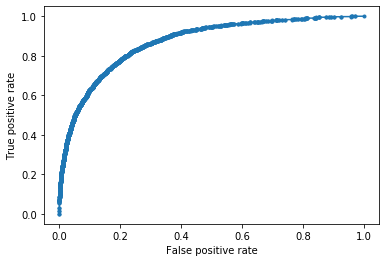

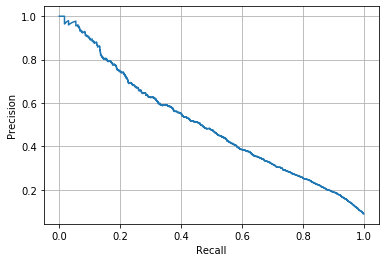

Area unde the curve for Precision-Recall Curve: 0.4989075844856886


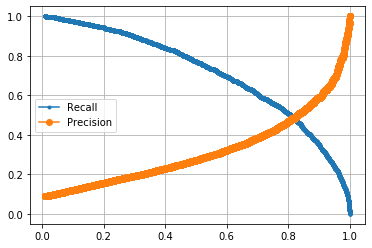

In [145]:
## Logistic regression with balanced data - oversampling and unweighted model
#lr_os.fit(X_train_os, y_train_os)
x_test = pipeline_full.transform(X_test)

lr_os_predict= lr_os.predict(x_test)
lr_os_predict_prob = lr_os.predict_proba(x_test)
print("Precision:",precision_score(y_test,lr_os_predict))
print("Recall:", recall_score(y_test,lr_os_predict))
print("Confusion matrix:", confusion_matrix(y_test,lr_os_predict))
fpr, tpr, threshold = roc_curve(y_test,lr_os_predict_prob[:,1])
plt.plot(fpr,tpr, marker='.')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()
precision, recall, threshold = precision_recall_curve(y_test,lr_os_predict_prob[:,1])
plt.plot(recall, precision)
#plt.axhline(y=0.086302, linestyle='--', color = 'red')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()
plt.plot(threshold, recall[1:], marker = '.', label = "Recall")
plt.plot(threshold, precision[1:], marker = 'o', label = "Precision")
plt.legend()
plt.grid()
print("Area unde the curve for Precision-Recall Curve:", auc(recall, precision))

In [79]:
## Logistic regression with imbalanced data and unweighted modelling
lr = LogisticRegression(penalty = 'l1', C = 0.8)
lr_cv = cross_val_score(lr, x_train, y_train, scoring = "roc_auc", cv = 5)
print("Averge CV score for Logistic Regression is {} +- {}".format(lr_cv.mean(), lr_cv.std()))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Averge CV score for Logistic Regression is 0.8826699145865946 +- 0.003392168526368627


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC score for Logistic regression is: 0.8779969002392666
Precision: 0.6836581709145427
Recall: 0.2880606443461781
Confusion matrix: [[16549   211]
 [ 1127   456]]


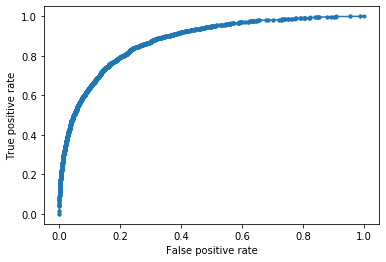

In [127]:
## Logistic regression with imbalanced data and unweighted modelling
lr.fit(x_train, y_train)
x_test = pipeline_full.transform(X_test)
y_predict = lr.predict(x_test)
lr_prob = lr.predict_proba(x_test)

print("ROC-AUC score for Logistic regression is:", roc_auc_score(y_test, lr_prob[:,1]))
fpr, tpr, threshold = roc_curve(y_test, lr_prob[:,1])
plt.plot(fpr,tpr, marker='.')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

print("Precision:",precision_score(y_test,y_predict))
print("Recall:", recall_score(y_test,y_predict))
print("Confusion matrix:", confusion_matrix(y_test,y_predict))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC score for Logistic regression is: 0.8799505334875173
Precision: 0.28789300797747536
Recall: 0.7751105495893872
Confusion matrix: [[13725  3035]
 [  356  1227]]


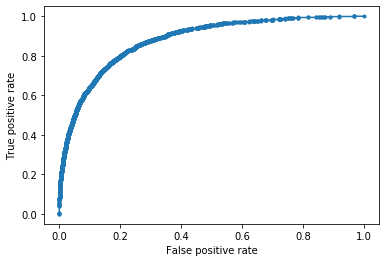

In [106]:
### ## Logistic regression with imbalanced data and modeled with class weights
lr_weight = LogisticRegression(penalty = 'l1', C = 0.8, class_weight='balanced')
lr_weight.fit(x_train, y_train)
y_predict_wt = lr_weight.predict(x_test)
lr_weight_prob = lr_weight.predict_proba(x_test)

print("ROC-AUC score for Logistic regression is:", roc_auc_score(y_test, lr_weight_prob[:,1]))
fpr, tpr, threshold = roc_curve(y_test, lr_weight_prob[:,1])
plt.plot(fpr,tpr, marker='.')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

print("Precision:",precision_score(y_test,y_predict_wt))
print("Recall:", recall_score(y_test,y_predict_wt))
print("Confusion matrix:", confusion_matrix(y_test,y_predict_wt))


- Logistic regression with Lasso regularization is used to perform feature selection
- ROC-AUC of the model is promising: 0.88
- Confusion matrix indicates that FN rate is high. Lets look at the precision-recall curve. It will be highly useful to understand the model fit, particularly for skewed or imblanaced dataset
- Precision score is 0.29 ==> model prediction for person's death is correct only 29% of the time. This indicates that this is a poor model
- Morever, recall is 0.77 => the model has detected only 77% of the patient death.
- Area under the PR-AUC is 0.5 -- indicating that it is a poor model. ROC-AUC is misleading in this scenario. To overcome this, let us oversample the minority data

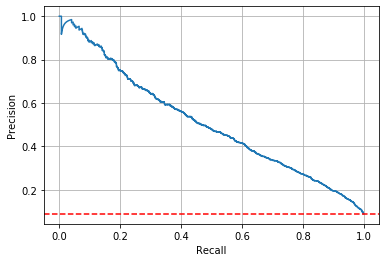

Area unde the curve for Precision-Recall Curve: 0.5098628338346509


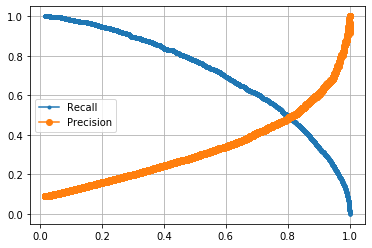

In [124]:
### ## Logistic regression with imbalanced data and modeled with class weights

precision, recall, threshold = precision_recall_curve(y_test, lr_weight_prob[:,1])
plt.plot(recall, precision)
plt.axhline(y=0.086302, linestyle='--', color = 'red')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()
plt.plot(threshold, recall[1:], marker = '.', label = "Recall")
plt.plot(threshold, precision[1:], marker = 'o', label = "Precision")
plt.legend()
plt.grid()
print("Area unde the curve for Precision-Recall Curve:", auc(recall, precision))

In [ ]:
cat_columns = X_train_dum.select_dtypes(include = 'uint8').columns.tolist()
num_cols = X_train_dum.select_dtypes(exclude = 'uint8').columns.tolist()
final_cols = num_cols + cat_columns